### `Paper` Al Khourdajie, A., Skea, J., & Green, R. (2024). Climate ambition, background scenario or the model? Attribution of the variance of energy-related indicators in global scenarios. Energy and Climate Change, 100126. ISSN 2666-2787. Available at: https://doi.org/10.1016/j.egycc.2024.100126.
### `Version` January 2024 
### `Authors` Alaa Al Khourdajie, Jim Skea, Richard Green

### Script: `Shapley-Owen Regression Analysis and Ternary Plots 3, 5, 9 and 11`
Code to implement the Shapley-Owen methodolgy and generating the results. 

Figures provided here are the individual ternary plots for the figures: 3, 5, 9 and 11. The full figures can be constructed based on the individual ternaries provided below. 

1. Import libraries and load the data

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import statsmodels.api as sm 
import patsy
from patsy import dmatrices
import re

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pylab
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline 

import warnings


In [2]:
# Load the prepared SSPs data
ssps_df = pd.read_csv("../05_data/df_ssps_cleaned.csv")

In [3]:
# dataframe describe
ssps_df.describe()

,Unnamed: 0,year,Primary_Energy,Primary_Energy_Wind,Primary_Energy_Solar,Primary_Energy_Biomass,Primary_Energy_Biomass_w_CCS,Primary_Energy_Hydro,Primary_Energy_Nuclear,Primary_Energy_Geothermal,...,Final_Energy_Gases,Final_Energy_Heat,Final_Energy_Liquids,Final_Energy_Solids,Final_Energy_Solar,Final_Energy_Electrification,Price_Carbon,GDP_PPP,cumulative_emissions,squared_cumulative_emissions
count,1270.00000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1200.000000,1270.000000,1270.000000,790.000000,...,1270.000000,1020.000000,1270.000000,1270.000000,630.000000,1270.000000,1.150000e+03,1270.000000,1270.000000,1.270000e+03
mean,634.50000,2055.000000,754.604110,45.502617,39.094701,110.294196,43.040660,21.047519,34.301396,3.329422,...,82.260698,15.837969,188.541961,67.103284,28.697332,0.345946,4.421554e-01,294.899930,2928.676941,1.175128e+07
std,366.76173,28.734128,233.157638,52.761159,52.287029,75.269297,73.222249,6.991660,37.966531,6.717801,...,43.096969,12.107126,76.567148,34.213986,26.467908,0.144403,1.739960e+00,202.574095,1782.311061,1.358800e+07
min,0.00000,2010.000000,320.039460,0.438500,0.091900,30.491735,0.000000,8.862000,0.000300,0.010000,...,1.006200,0.007765,6.100989,0.311200,0.121414,0.166853,0.000000e+00,64.808103,126.585175,1.602381e+04
25%,317.25000,2030.000000,586.795578,8.530225,3.763900,58.085600,0.000000,15.854228,12.072246,0.360550,...,54.316913,7.722811,145.006528,42.549043,6.075682,0.234879,1.303597e-22,144.812906,1483.215644,2.199929e+06
50%,634.50000,2055.000000,710.327984,26.696415,22.624201,84.666403,2.952582,20.764100,21.396979,0.845350,...,75.042744,12.245000,181.865958,65.556269,23.980082,0.307968,4.066640e-02,247.254192,2750.123960,7.563182e+06
75%,951.75000,2080.000000,858.498625,61.327165,52.348618,141.624925,59.437624,24.599700,39.794963,3.896118,...,102.298580,21.769775,229.511667,90.199245,42.789487,0.429348,2.461900e-01,397.993530,4103.959651,1.684248e+07
max,1269.00000,2100.000000,1824.000000,388.534660,395.800000,477.000000,417.200000,47.630000,251.698000,55.470000,...,281.913000,84.123000,586.378096,243.141000,163.365636,0.902031,3.185248e+01,1034.177000,8236.910903,6.784670e+07


In [4]:
# Data types of the columns in the dataframe
ssps_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1270 entries, 0 to 1269
Data columns (total 51 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Unnamed: 0                                        1270 non-null   int64  
 1   model                                             1270 non-null   object 
 2   scenario                                          1270 non-null   object 
 3   year                                              1270 non-null   int64  
 4   rcp                                               1270 non-null   object 
 5   mod_scen_combined                                 1270 non-null   object 
 6   Primary_Energy                                    1270 non-null   float64
 7   Primary_Energy_Wind                               1270 non-null   float64
 8   Primary_Energy_Solar                              1270 non-null   float64
 9   Primary_Energy_Biom

In [5]:
# Reorder SSPs to start with SSP2 such that the combination of AIM/CGE (model) + SSP2 (scenario) 
# is used as the constant in the regressions, as per the analysis of this paper
ssps_df['scenario'] = pd.Categorical(ssps_df['scenario'], ['SSP2', 'SSP1', 'SSP3', 'SSP4', 'SSP5'])
ssps_df.scenario.unique()

['SSP1', 'SSP2', 'SSP3', 'SSP4', 'SSP5']
Categories (5, object): ['SSP2', 'SSP1', 'SSP3', 'SSP4', 'SSP5']

In [6]:
# List of all columns
ssps_df.columns.unique()

Index(['Unnamed: 0', 'model', 'scenario', 'year', 'rcp', 'mod_scen_combined',
       'Primary_Energy', 'Primary_Energy_Wind', 'Primary_Energy_Solar',
       'Primary_Energy_Biomass', 'Primary_Energy_Biomass_w_CCS',
       'Primary_Energy_Hydro', 'Primary_Energy_Nuclear',
       'Primary_Energy_Geothermal', 'Primary_Energy_Fossil',
       'Primary_Energy_Fossil_w_CCS', 'Primary_Energy_Fossil_wo_CCS',
       'Primary_Energy_Coal', 'Primary_Energy_Coal_w_CCS',
       'Primary_Energy_Coal_wo_CCS', 'Primary_Energy_Oil',
       'Primary_Energy_Oil_w_CCS', 'Primary_Energy_Oil_wo_CCS',
       'Primary_Energy_Gas', 'Primary_Energy_Gas_w_CCS',
       'Primary_Energy_Gas_wo_CCS', 'Primary_Energy_Non_Biomass_Renewables',
       'Emissions_CO2', 'Emissions_CH4', 'Emissions_N2O',
       'Emissions_Kyoto_Gases', 'Emissions_CO2_Carbon_Capture_and_Storage',
       'Emissions_CO2_Carbon_Capture_and_Storage_Biomass',
       'Emissions_CO2_Fossil_Fuels_and_Industry', 'Emissions_CO2_Land_Use',
       'Fina

In [7]:
# List of dependent variable that are of interest for this analysis
variables = [
       # Primary Energy      
       'Primary_Energy', 
       'Primary_Energy_Wind',
       'Primary_Energy_Solar', 
       'Primary_Energy_Biomass',
       'Primary_Energy_Biomass_w_CCS', 
       'Primary_Energy_Hydro',
       'Primary_Energy_Nuclear', 
       'Primary_Energy_Geothermal', 
       'Primary_Energy_Non_Biomass_Renewables',
       'Primary_Energy_Fossil',
       "Primary_Energy_Fossil_w_CCS",
       "Primary_Energy_Fossil_wo_CCS",
       'Primary_Energy_Coal',
       'Primary_Energy_Coal_w_CCS',
       'Primary_Energy_Coal_wo_CCS',
       'Primary_Energy_Oil',
       'Primary_Energy_Oil_w_CCS',
       'Primary_Energy_Oil_wo_CCS',
       'Primary_Energy_Gas',
       "Primary_Energy_Gas_w_CCS",
       "Primary_Energy_Gas_wo_CCS",

       # Final Energy
       'Final_Energy', 
       'Final_Energy_Electricity', 
       'Final_Energy_Gases',
       'Final_Energy_Heat', 
       'Final_Energy_Liquids', 
       'Final_Energy_Solids',
       'Final_Energy_Hydrogen', 
       'Final_Energy_Solar', 
       'Final_Energy_Industry',
       'Final_Energy_Residential_and_Commercial',
       'Final_Energy_Transportation',
       'Final_Energy_Electrification',
       
       # Emissions
       'Emissions_CO2',
       'Emissions_CH4',
       'Emissions_N2O', 
       'Emissions_Kyoto_Gases',
       'Emissions_CO2_Carbon_Capture_and_Storage',
       'Emissions_CO2_Carbon_Capture_and_Storage_Biomass',
       'Emissions_CO2_Fossil_Fuels_and_Industry', 
       'Emissions_CO2_Land_Use',

       # Economic variables 
       'Price_Carbon',
       'GDP_PPP',
        
       ]

2) Methodology: Shapley-Owen Value Function

In [8]:
### --------------
# Shapley-Owen Value Function
### --------------

### -------------- Overview of the Shapley-Owen decomposition function --------------
# The function below is the Shapley-Owen decomposition function.
# For background on the Shapley-Owen decomposition, see section 2.3 and Appendix A of the paper.
# The function also undertakes additional appraoches to the Shapley-Owen decomposition, as described in Appendix E of the paper.
# --------------

# -------------- Structure of the code --------------
# The function below is structured as follows:
# BLOCK A: Descriptive Stats
# BLOCK B: Regressions
# BLOCK C: Preparation of columns for input in the final table
# BLOCK D: Preparation of columns for plotting
# BLOCK E: Build the table that contains each step of the calculations above
# --------------

# -------------- Inputs --------------
# The function below takes two inputs:
# 1) variable: the dependent variables
# 2) data: the dataframe prepared in script 01
# --------------

# -------------- Code of the Function --------------
def shapley_owen_decomposition (variable, data):
    # An empty table to fill with the calculations later on
    df=[]
    # An array of the decadal years 2020-2100, for the regression loop 
    years = data.year[1:10].unique()
    for i in years:
        # BLOCK A: Descriptive Stats
        # Generate the basic descriptive stats for the dependent variable for each decadal year
        avg=np.average(data[variable].loc[(data['year'] == i)])
        median=np.median(data[variable].loc[(data['year'] == i)])
        StDev=np.std(data[variable].loc[(data['year'] == i)])
        # Generate the 90th percentile for the dependent variable for each decadal year
        percentile_90=np.percentile(data[variable].loc[(data['year'] == i)], 90)
        # Generate the 75th percentile for the dependent variable for each decadal year
        percentile_75=np.percentile(data[variable].loc[(data['year'] == i)], 75)

        # BLOCK B: Regressions 
        # 1) Univariate regression: Ambition
        # Prepare the regression variables
        dmatrices_Amb = str(variable + ' ~ cumulative_emissions + squared_cumulative_emissions')
        y, X = dmatrices(
            dmatrices_Amb,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Amb_results = model.fit()
        # 1a) Univariate RCP regression: RCP [This is an additional regression to the one in the paper. RCP regressions are included in Appendix E]
        # Prepare the regression variables
        dmatrices_Amb_rcp = str(variable + ' ~ rcp')
        y, X = dmatrices(
            dmatrices_Amb_rcp,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Amb_rcp_results = model.fit()
        # 2) Univariate regression: Scenario
        # Prepare the regression variables
        dmatrices_Scen = str(variable + ' ~ scenario')
        y, X = dmatrices(
            dmatrices_Scen,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Scen_results = model.fit()
        # 3) Univariate regression: Model
        # Prepare the regression variables
        dmatrices_Mod = str(variable + ' ~ model')
        y, X = dmatrices(
            dmatrices_Mod,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Mod_results = model.fit()
        # 4) Multivariate regression: Climate ambition and scenario
        # Prepare the regression variables
        dmatrices_Amb_Scen = str(variable + ' ~ cumulative_emissions + squared_cumulative_emissions + scenario')
        y, X = dmatrices(
            dmatrices_Amb_Scen,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Amb_Scen_results = model.fit()
        # 4a) Multivariate RCP regression: rcp and scenario
        # Prepare the regression variables
        dmatrices_Amb_rcp_Scen = str(variable + ' ~ rcp + scenario')
        y, X = dmatrices(
            dmatrices_Amb_rcp_Scen,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Amb_rcp_Scen_results = model.fit()
        # 5) Multivariate regression: Climate ambition and model
        # Prepare the regression variables
        dmatrices_Amb_Mod = str(variable + ' ~ cumulative_emissions + squared_cumulative_emissions + model')
        y, X = dmatrices(
            dmatrices_Amb_Mod,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Amb_Mod_results = model.fit()
        # 5a) Multivariate RCP regression: Climate ambition and model
        # Prepare the regression variables
        dmatrices_Amb_rcp_Mod = str(variable + ' ~ rcp + model')
        y, X = dmatrices(
            dmatrices_Amb_rcp_Mod,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Amb_rcp_Mod_results = model.fit()
        # 6) Multivariate regression: Scenario and model
        # Prepare the regression variables
        dmatrices_Scen_Mod = str(variable + ' ~ scenario + model')
        y, X = dmatrices(
            dmatrices_Scen_Mod,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Scen_Mod_results = model.fit()
        # 7) Multivariate regression: climate ambition, scenario and model
        # Prepare the regression variables
        dmatrices_Amb_Scen_Mod = str(variable + ' ~ cumulative_emissions + squared_cumulative_emissions + scenario + model')
        y, X = dmatrices(
            dmatrices_Amb_Scen_Mod,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Amb_Scen_Mod_results = model.fit()
        # 7a) Multivariate RCP regression: climate ambition, scenario and model
        # Prepare the regression variables
        dmatrices_Amb_rcp_Scen_Mod = str(variable + ' ~ rcp + scenario + model')
        y, X = dmatrices(
            dmatrices_Amb_rcp_Scen_Mod,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Amb_rcp_Scen_Mod_results = model.fit()
        
        # BLOCK C: Preparation of columns for input in the final table
        # Step 1: R2 of the regressions:
        R2_Amb =                Amb_results.rsquared
        R2_Amb_rcp =            Amb_rcp_results.rsquared   
        R2_Scen =               Scen_results.rsquared
        R2_Mod =                Mod_results.rsquared

        R2_Amb_Scen =           Amb_Scen_results.rsquared
        R2_Amb_rcp_Scen =       Amb_rcp_Scen_results.rsquared
        R2_Amb_Mod =            Amb_Mod_results.rsquared
        R2_Amb_rcp_Mod =        Amb_rcp_Mod_results.rsquared
        R2_Scen_Mod =           Scen_Mod_results.rsquared

        R2_Amb_Scen_Mod =       Amb_Scen_Mod_results.rsquared
        R2_Amb_rcp_Scen_Mod =   Amb_rcp_Scen_Mod_results.rsquared

        R2_Residual =           1 - R2_Amb_Scen_Mod
        R2_Residual_rcp =       1 - R2_Amb_rcp_Scen_Mod

        # Step 2: Shapley Decomposition
        R2_Amb_Shapley = (
                            (R2_Amb                                     /   3) + \
                            ((R2_Amb_Scen       -       R2_Scen)        /   6) + \
                            ((R2_Amb_Mod        -       R2_Mod)         /   6) + \
                            ((R2_Amb_Scen_Mod   -       R2_Scen_Mod)    /   3)
                        )
        R2_Scen_Shapley = (
                            (R2_Scen                                     /   3) + \
                            ((R2_Amb_Scen       -       R2_Amb)          /   6) + \
                            ((R2_Scen_Mod       -       R2_Mod)          /   6) + \
                            ((R2_Amb_Scen_Mod   -       R2_Amb_Mod)      /   3)
                        )
        R2_Mod_Shapley = (
                            (R2_Mod                                      /   3) + \
                            ((R2_Amb_Mod        -       R2_Amb)          /   6) + \
                            ((R2_Scen_Mod       -       R2_Scen)         /   6) + \
                            ((R2_Amb_Scen_Mod   -       R2_Amb_Scen)     /   3)
                        )
        # Sum of Shapley Values
        R2_Amb_Scen_Mod_Shapley = R2_Amb_Shapley + R2_Scen_Shapley + R2_Mod_Shapley

        # The below test must = 0
        Test_R2_Shapley_vs_R2 = R2_Amb_Scen_Mod - R2_Amb_Scen_Mod_Shapley

        # Step 2a: Shapley Decomposition - rcp [This is an additional regression to the one in the paper. RCP regressions are included in Appendix E]
        R2_Amb_Shapley_rcp = (
                            (R2_Amb_rcp                                     /   3) + \
                            ((R2_Amb_rcp_Scen       -       R2_Scen)        /   6) + \
                            ((R2_Amb_rcp_Mod        -       R2_Mod)         /   6) + \
                            ((R2_Amb_rcp_Scen_Mod   -       R2_Scen_Mod)    /   3)
                        )
        R2_Scen_Shapley_rcp = (
                            (R2_Scen                                        /   3) + \
                            ((R2_Amb_rcp_Scen       -       R2_Amb_rcp)     /   6) + \
                            ((R2_Scen_Mod       -       R2_Mod)             /   6) + \
                            ((R2_Amb_rcp_Scen_Mod   -       R2_Amb_rcp_Mod) /   3)
                        )
        R2_Mod_Shapley_rcp = (
                            (R2_Mod                                         /   3) + \
                            ((R2_Amb_rcp_Mod        -       R2_Amb_rcp)     /   6) + \
                            ((R2_Scen_Mod       -       R2_Scen)            /   6) + \
                            ((R2_Amb_rcp_Scen_Mod   -       R2_Amb_rcp_Scen)/   3)
                        )
        # Sum of Shapley Values
        R2_Amb_rcp_Scen_Mod_Shapley = R2_Amb_Shapley_rcp + R2_Scen_Shapley_rcp + R2_Mod_Shapley_rcp

        # The below test must = 0
        Test_R2_Shapley_vs_R2_rcp = R2_Amb_rcp_Scen_Mod - R2_Amb_rcp_Scen_Mod_Shapley

        # Step 3
        # We prepare the following columns which will be used to plot stacked bar charts.
        # These stacked bar chart will show the R2 in the explanatory variables 
        # and the decomposition of this R2 variability by the three effects identified.
        # The decomposition will be illustrated using the stacks in the stacked bar charts. 
        Avg_SD =        (avg - StDev)
        # The heights of individual effects, is the product of *relevant R2 times 2 standard deviation*
        SD2_Amb =                       (2 * StDev * R2_Amb_Shapley)
        SD2_Scen=                       (2 * StDev * R2_Scen_Shapley)
        SD2_Mod =                       (2 * StDev * R2_Mod_Shapley)
        SD2_Resid =                     (2 * StDev * R2_Residual)
        
        # The "if function" in this BLOCK D below checks for negative values of AVG-SD and 
        # provide the input for variables to be plotted. These values below are the ones that are plotted in 
        # the Shapley Decomposition plots.
        if Avg_SD >= 0:
            Plot_Avg_SD = Avg_SD
        else:
            Plot_Avg_SD = 0
        # We also create similar column that does the reverse of the above.
        if Avg_SD < 0:
            Plot_Avg_SD_Surrogate = Avg_SD
        else:
            Plot_Avg_SD_Surrogate = 0 
        
        # The following calculations are to ensure that the 4 SD2 stacks defined above are 
        # centered about the mean
        Low_end = Plot_Avg_SD + Plot_Avg_SD_Surrogate
        High_end = SD2_Amb + SD2_Scen + SD2_Mod + SD2_Resid + Plot_Avg_SD + Plot_Avg_SD_Surrogate
        Length = High_end + Low_end
        Mid_point = Length / 2
        Avg_vs_Mid_point = avg - Mid_point # which must equal to zero in the final table

        # Step 3a [This is an additional regression to the one in the paper. RCP regressions are included in Appendix E]
        # We prepare the following columns which will be used to plot stacked bar charts.
        # These stacked bar chart will show the R2 in the explanatory variables
        # and the decomposition of this R2 variability by the three effects identified above.
        # The decomposition will be illustrated using the stacks in the stacked bar charts.
        Avg_SD =        (avg - StDev)
        # The heights of individual effects, is the product of *relevant R2 times 2 standard deviation*
        SD2_Amb_rcp =                       (2 * StDev * R2_Amb_Shapley_rcp)
        SD2_Scen_rcp=                       (2 * StDev * R2_Scen_Shapley_rcp)
        SD2_Mod_rcp =                       (2 * StDev * R2_Mod_Shapley_rcp)
        SD2_Resid_rcp =                     (2 * StDev * R2_Residual_rcp)

        # The "if function" in this BLOCK D below checks for negative values of AVG-SD and
        # provide the input for variables to be plotted. These values below are the ones that are plotted in
        # the Shapley Decomposition plots.
        if Avg_SD >= 0:
            Plot_Avg_SD_rcp = Avg_SD
        else:
            Plot_Avg_SD_rcp = 0
        # We also create similar column that does the reverse of the above.
        if Avg_SD < 0:
            Plot_Avg_SD_Surrogate_rcp = Avg_SD
        else:
            Plot_Avg_SD_Surrogate_rcp = 0

        # The following calculations are to ensure that the 4 SD2 stacks defined above are
        # centered about the mean
        Low_end_rcp = Plot_Avg_SD_rcp + Plot_Avg_SD_Surrogate_rcp
        High_end_rcp = SD2_Amb_rcp + SD2_Scen_rcp + SD2_Mod_rcp + SD2_Resid_rcp + Plot_Avg_SD_rcp + Plot_Avg_SD_Surrogate_rcp
        Length_rcp = High_end_rcp + Low_end_rcp
        Mid_point_rcp = Length_rcp / 2
        Avg_vs_Mid_point_rcp = avg - Mid_point_rcp
                
        # BLOCK E:
        # Here we build the table that contains each step of the calculations above 
        df.append(
                {
                # The following set of columns contain the descriptive stats (from BLOCK A above) and the R2 of regressions (BLOCK C)
                'Variable'                  :       variable,
                'Year'                      :       i,
                'Average'                   :       avg,
                'Median'                    :       median,
                'StDev'                     :       StDev,
                'percentile_90'             :       percentile_90,
                'percentile_75'             :       percentile_75,
                'Avg-SD'                    :       Avg_SD,
                'R2_Amb'                    :       R2_Amb,
                'R2_Scen'                   :       R2_Scen,
                'R2_Mod'                    :       R2_Mod,
                'R2_Amb_Scen'               :       R2_Amb_Scen,
                'R2_Amb_Mod'                :       R2_Amb_Mod,
                'R2_Scen_Mod'               :       R2_Scen_Mod,
                'R2_Amb_Scen_Mod'           :       R2_Amb_Scen_Mod,
                'R2_Residual'               :       R2_Residual,

                # The following set of columns contain the Shapley value calculations (BLOCK C)
                'R2_Amb_Shapley'            :       R2_Amb_Shapley,
                'R2_Scen_Shapley'           :       R2_Scen_Shapley,
                'R2_Mod_Shapley'            :       R2_Mod_Shapley,
                'R2_Amb_Scen_Mod_Shapley'   :       R2_Amb_Scen_Mod_Shapley,
                'Test_R2_Shapley_vs_R2'     :       int(Test_R2_Shapley_vs_R2),

                # The following set of columns contain the data from plotting
                'Plot_Avg_SD'               :       Plot_Avg_SD,
                'Plot_Avg_SD_Surrogate'     :       Plot_Avg_SD_Surrogate,
                'Plot_Amb'                  :       SD2_Amb,
                'Plot_Scen'                 :       SD2_Scen,
                'Plot_Mod'                  :       SD2_Mod,
                'Plot_Resid'                :       SD2_Resid,
                'Avg_vs_Mid_point'          :       int(Avg_vs_Mid_point),

                # Add normalised values of R2_Amb_Shapley, R2_Scen_Shapley, R2_Mod_Shapley
                'R2_Amb_Scen_Mod_Shapleys_sum' :    R2_Amb_Scen_Mod_Shapley,
                'R2_Amb_Shapley_norm'       :       R2_Amb_Shapley / R2_Amb_Scen_Mod_Shapley,
                'R2_Scen_Shapley_norm'      :       R2_Scen_Shapley / R2_Amb_Scen_Mod_Shapley,
                'R2_Mod_Shapley_norm'       :       R2_Mod_Shapley / R2_Amb_Scen_Mod_Shapley,

                # The following set of columns will replicate the above but for the RCP decomposition 
                # [This is an additional regression to the one in the paper. RCP regressions are included in Appendix E]
                # The following set of columns contain the descriptive stats (from BLOCK A above) and the R2 of regressions (BLOCK C)
                'R2_Amb_rcp'                    :       R2_Amb_rcp,
                'R2_Scen_rcp'                   :       R2_Scen,
                'R2_Mod_rcp'                    :       R2_Mod,
                'R2_Amb_rcp_Scen'               :       R2_Amb_rcp_Scen,
                'R2_Amb_rcp_Mod'                :       R2_Amb_rcp_Mod,
                'R2_Scen_rcp_Mod'               :       R2_Scen_Mod,
                'R2_Amb_rcp_Scen_Mod'           :       R2_Amb_rcp_Scen_Mod,
                'R2_Residual_rcp'               :       R2_Residual_rcp,

                # The following set of columns contain the Shapley value calculations (BLOCK C)
                'R2_Amb_Shapley_rcp'            :       R2_Amb_Shapley_rcp,
                'R2_Scen_Shapley_rcp'           :       R2_Scen_Shapley_rcp,
                'R2_Mod_Shapley_rcp'            :       R2_Mod_Shapley_rcp,
                'R2_Amb_rcp_Scen_Mod_Shapley'   :       R2_Amb_rcp_Scen_Mod_Shapley,
                'Test_R2_Shapley_vs_R2_rcp'     :       int(Test_R2_Shapley_vs_R2_rcp),

                # The following set of columns contain the data from plotting
                'Plot_Avg_SD_rcp'               :       Plot_Avg_SD_rcp,
                'Plot_Avg_SD_Surrogate_rcp'     :       Plot_Avg_SD_Surrogate_rcp,
                'Plot_Amb_rcp'                  :       SD2_Amb_rcp,
                'Plot_Scen_rcp'                 :       SD2_Scen_rcp,
                'Plot_Mod_rcp'                  :       SD2_Mod_rcp,
                'Plot_Resid_rcp'                :       SD2_Resid_rcp,
                'Avg_vs_Mid_point_rcp'          :       int(Avg_vs_Mid_point_rcp),

                # Add normalised values of R2_Amb_Shapley, R2_Scen_Shapley, R2_Mod_Shapley
                'R2_Amb_rcp_Scen_Mod_Shapleys_sum' :    R2_Amb_rcp_Scen_Mod_Shapley,
                'R2_Amb_Shapley_rcp_norm'       :       R2_Amb_Shapley_rcp / R2_Amb_rcp_Scen_Mod_Shapley,
                'R2_Scen_Shapley_rcp_norm'      :       R2_Scen_Shapley_rcp / R2_Amb_rcp_Scen_Mod_Shapley,
                'R2_Mod_Shapley_rcp_norm'       :       R2_Mod_Shapley_rcp / R2_Amb_rcp_Scen_Mod_Shapley,

                }
                )
    df = pd.DataFrame(df)
    df
    return(df)

3) Apply the function on the prepared SSPs data

In [9]:
# list of all dependent variables
variables

['Primary_Energy',
 'Primary_Energy_Wind',
 'Primary_Energy_Solar',
 'Primary_Energy_Biomass',
 'Primary_Energy_Biomass_w_CCS',
 'Primary_Energy_Hydro',
 'Primary_Energy_Nuclear',
 'Primary_Energy_Geothermal',
 'Primary_Energy_Non_Biomass_Renewables',
 'Primary_Energy_Fossil',
 'Primary_Energy_Fossil_w_CCS',
 'Primary_Energy_Fossil_wo_CCS',
 'Primary_Energy_Coal',
 'Primary_Energy_Coal_w_CCS',
 'Primary_Energy_Coal_wo_CCS',
 'Primary_Energy_Oil',
 'Primary_Energy_Oil_w_CCS',
 'Primary_Energy_Oil_wo_CCS',
 'Primary_Energy_Gas',
 'Primary_Energy_Gas_w_CCS',
 'Primary_Energy_Gas_wo_CCS',
 'Final_Energy',
 'Final_Energy_Electricity',
 'Final_Energy_Gases',
 'Final_Energy_Heat',
 'Final_Energy_Liquids',
 'Final_Energy_Solids',
 'Final_Energy_Hydrogen',
 'Final_Energy_Solar',
 'Final_Energy_Industry',
 'Final_Energy_Residential_and_Commercial',
 'Final_Energy_Transportation',
 'Final_Energy_Electrification',
 'Emissions_CO2',
 'Emissions_CH4',
 'Emissions_N2O',
 'Emissions_Kyoto_Gases',
 'Em

In [10]:
# check for NaNs in the dependent variables
count_nan_in_df = ssps_df.isnull().sum()
count_nan_in_df = pd.DataFrame(count_nan_in_df, columns=['NAs'])
count_nan_in_df

,NAs
Unnamed: 0,0
model,0
scenario,0
year,0
rcp,0
mod_scen_combined,0
Primary_Energy,0
Primary_Energy_Wind,0
Primary_Energy_Solar,0
Primary_Energy_Biomass,0


In [11]:
# Applying the function to all dependent variables
# The below loop uses the count_nan_in_df table above in order to 
# drop the NAs rows from the data (ssps_df) only for the variables 
# with NaNs

# Clear objects before running the loop 
df=[]
df_list=[]
data=[]

for v in variables: # that is all dependent variables identified above
    if count_nan_in_df.loc[v,'NAs'] == 0: 
        data = ssps_df
        df = shapley_owen_decomposition(v, data)
        df_list.append(df)
    # if there are NaNs for certain variables then
    # the function will run on a subset of the data that omits the NaNs
    # and the corresponding columns
    else:
        data = ssps_df.dropna(subset=[v])
        df = shapley_owen_decomposition(v, data)
        df_list.append(df)        
df_all = pd.concat(df_list)
df_all

,Variable,Year,Average,Median,StDev,percentile_90,percentile_75,Avg-SD,R2_Amb,R2_Scen,...,Plot_Avg_SD_Surrogate_rcp,Plot_Amb_rcp,Plot_Scen_rcp,Plot_Mod_rcp,Plot_Resid_rcp,Avg_vs_Mid_point_rcp,R2_Amb_rcp_Scen_Mod_Shapleys_sum,R2_Amb_Shapley_rcp_norm,R2_Scen_Shapley_rcp_norm,R2_Mod_Shapley_rcp_norm
0,Primary_Energy,2020,592.632501,590.293832,36.344500,637.097282,619.800000,556.288000,0.154003,0.458154,...,0.0,5.432936,31.845336,20.915194,14.495535,0,0.800581,0.093360,0.547232,0.359408
1,Primary_Energy,2030,652.114384,660.993132,107.144662,778.820990,718.468824,544.969722,0.401768,0.262821,...,0.0,78.425954,43.513784,48.624245,43.725342,0,0.795952,0.459804,0.255117,0.285079
2,Primary_Energy,2040,713.072097,716.093316,143.405963,889.381723,787.556742,569.666134,0.523812,0.311684,...,0.0,124.277108,73.227310,50.657487,38.650022,0,0.865243,0.500790,0.295079,0.204131
3,Primary_Energy,2050,768.841860,766.231300,173.245985,993.536219,853.573152,595.595875,0.531905,0.410085,...,0.0,133.842191,123.954285,49.104141,39.591352,0,0.885737,0.436109,0.403891,0.160000
4,Primary_Energy,2060,811.542265,792.744375,202.542032,1072.157164,912.971710,609.000232,0.540899,0.469406,...,0.0,141.758922,171.177758,47.498710,44.648676,0,0.889779,0.393299,0.474919,0.131781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,GDP_PPP,2060,313.319643,280.515400,90.118210,467.491600,355.400000,223.201433,0.040172,0.974897,...,0.0,0.396960,168.414255,10.127686,1.297519,0,0.992801,0.002218,0.941183,0.056599
5,GDP_PPP,2070,373.698450,336.848500,123.763739,590.612400,419.291187,249.934711,0.044672,0.978820,...,0.0,0.467994,231.691988,13.737584,1.629911,0,0.993415,0.001903,0.942230,0.055867
6,GDP_PPP,2080,434.676270,398.498200,159.940390,722.843200,475.419188,274.735880,0.049324,0.981165,...,0.0,0.529475,299.586376,17.776548,1.988380,0,0.993784,0.001666,0.942414,0.055920
7,GDP_PPP,2090,496.656784,465.175700,198.808204,861.958600,524.875813,297.848579,0.054261,0.982979,...,0.0,0.633629,372.668716,22.006201,2.307862,0,0.994196,0.001603,0.942729,0.055668


4) Cleaning the final output to prepare the dataframe for plotting in the following steps

In [12]:
# In the Variable column of df_all, remove the "_" from the values
df_all['Variable'] = df_all['Variable'].str.replace('_', ' ')

In [13]:
# In all variables that include wo CCS, delete the wo CCS, add "Unabated" instead

def replace_wo_CCS(text):
    return re.sub(r'(\w+)\swo\sCCS', r'Unabated \1', text)

df_all['Variable'] = df_all['Variable'].apply(replace_wo_CCS)



In [14]:
# Adding Typology to the variables
# Typologies are: Emissions, Fossil PE, Non-fossil PE, Final Energy, CCS/Land
# Variables will be assigned to type according to the following loops:

# Creating additional colum for Type
Labels = ['Emissions ']
for i in Labels:
    df_all.loc[df_all['Variable'].str.contains(str(i)), 'Type'] = 'Emissions'

Labels = ['Final Energy']
for i in Labels:
    df_all.loc[df_all['Variable'].str.contains(str(i)), 'Type'] = 'Final Energy'

Labels = ['Primary Energy',
         'Primary Energy Fossil',
            "Primary Energy Fossil w CCS",
            "Primary Energy Unabated Fossil",
            'Primary Energy Coal',
            'Primary Energy Coal w CCS',
            'Primary Energy Unabated Coal',
            'Primary Energy Gas',
            "Primary Energy Gas w CCS",
            "Primary Energy Unabated Gas",
            'Primary Energy Oil',
            'Primary Energy Oil w CCS',
            'Primary Energy Unabated Oil',
    ]

for i in Labels:
    df_all.loc[df_all['Variable'].str.contains(str(i)), 'Type'] = 'Fossil'

Labels = [
         'Primary Energy Wind',
            'Primary Energy Solar',
            'Primary Energy Biomass',
            'Primary Energy Biomass w CCS',
            'Primary Energy Hydro',
            'Primary Energy Nuclear',
            'Primary Energy Geothermal',
            'Primary Energy Non Biomass Renewables',
    ]

for i in Labels:
    df_all.loc[df_all['Variable'].str.contains(str(i)), 'Type'] = 'Non-fossil'

Labels = [
        'Price Carbon',
       'GDP PPP'
       ]
for i in Labels:
    df_all.loc[df_all['Variable'].str.contains(str(i)), 'Type'] = 'Economic'

df_all.Type.unique()

array(['Fossil', 'Non-fossil', 'Final Energy', 'Emissions', 'Economic'],
      dtype=object)

In [15]:
# # Export to CSV
df_all.to_csv('../05_data/shapley-Owen_results_all_variables.csv')

5) Ternary plots 3, 5, 9 and 11

Figures provided here are the individual ternary plots for the figures: 3, 5, 9 and 11. The full figures can be constructed based on the individual ternaries provided below. 

5_a) Preparing the data

In [16]:
# The individual ternary plots for Figures 3, 5, 9 and 11 are tailored for the purpose of our paper. 
# They include two triangles, outer and inner, where the difference between the two illustrates the residual variance.
# The solid line under the outer triangle represents the unit length.
# Please check section 3.2 of the paper, more specifically the text for Figure 2, 
# for more details on the geometric representation of the Shapley-Owen decomposition.

# --------------
# Constant parameters for calculations
# --------------
axis_length = 1.5  # Represents the length of the axis of the space
minimum_outer = 0.5  # Represents the minimum length of the outer triangle/ternary
radians_60_degrees = 1.047197551  # Radian measure of a 60-degree angle, used to calculate the coordinates of the geometric shapes

# --------------
# Data to be plotted
# --------------

# Coefficient of Variation (CV - standard deviation divided by average)
df_all.loc[:, 'CV'] = df_all['StDev'].divide(df_all['Average'], fill_value=np.nan)

# 'Outer_length': the minimum of axis_length and the maximum of minimum_outer and CV
df_all.loc[:, 'Outer_length'] = df_all['CV'].apply(lambda x: min(axis_length, max(minimum_outer, x)))

# 'Inner_length': Outer_length adjusted by the residual variance (R2_Residual)
df_all.loc[:, 'Inner_length'] = df_all['Outer_length'] * (1 - df_all['R2_Residual'])

# X and Y coordinates for outer and inner triangles
df_all.loc[:, 'X_outer_left'] = (axis_length / 2) - (df_all['Outer_length'] / 2)
df_all.loc[:, 'Y_outer_base'] = df_all['X_outer_left'] / np.tan(radians_60_degrees)
df_all.loc[:, 'X_outer_right'] = df_all['X_outer_left'] + df_all['Outer_length']
df_all.loc[:, 'X_outer_top'] = axis_length / 2
df_all.loc[:, 'Y_outer_top'] = df_all['Y_outer_base'] + (np.tan(radians_60_degrees) * (df_all['Outer_length'] / 2))
df_all.loc[:, 'X_inner_left'] = (axis_length / 2) - (df_all['Inner_length'] / 2)
df_all.loc[:, 'Y_inner_base'] = df_all['X_inner_left'] / np.tan(radians_60_degrees)
df_all.loc[:, 'X_inner_right'] = df_all['X_inner_left'] + df_all['Inner_length']
df_all.loc[:, 'X_inner_top'] = axis_length / 2
df_all.loc[:, 'Y_inner_top'] = df_all['Y_inner_base'] + (np.tan(radians_60_degrees) * (df_all['Inner_length'] / 2))

# 'X_data_point' and 'Y_data_point' to represent data points in the inner triangle/ternary
df_all.loc[:, 'X_data_point'] = df_all['X_inner_left'] + \
    ((df_all['R2_Scen_Shapley'] + df_all['R2_Amb_Shapley'] * np.cos(radians_60_degrees)) * \
     df_all['Outer_length'])

df_all.loc[:, 'Y_data_point'] = df_all['Y_inner_base'] + \
    (df_all['R2_Amb_Shapley'] * np.sin(radians_60_degrees) * df_all['Outer_length'])


5_b) Plotting the individual figures

The intution of the below figures is exaplined in Figure 2 of the paper.

![Alt text](image.png)

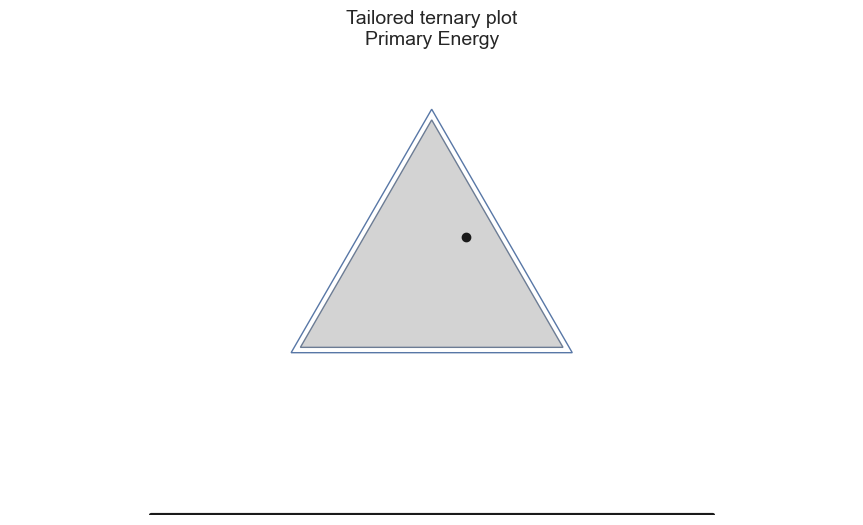

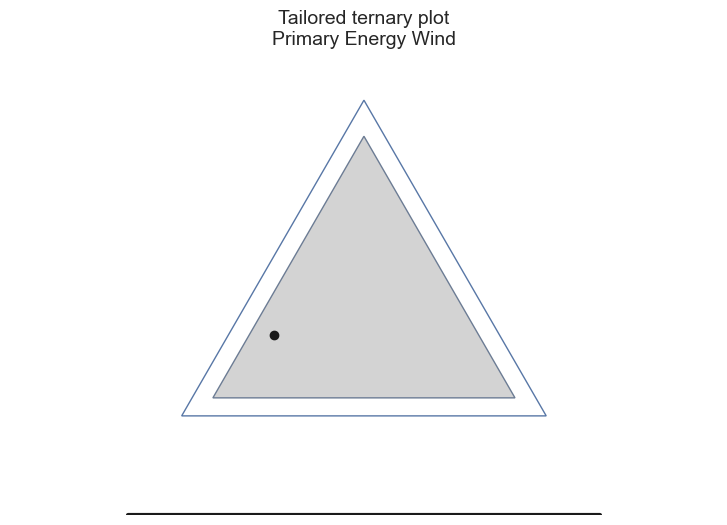

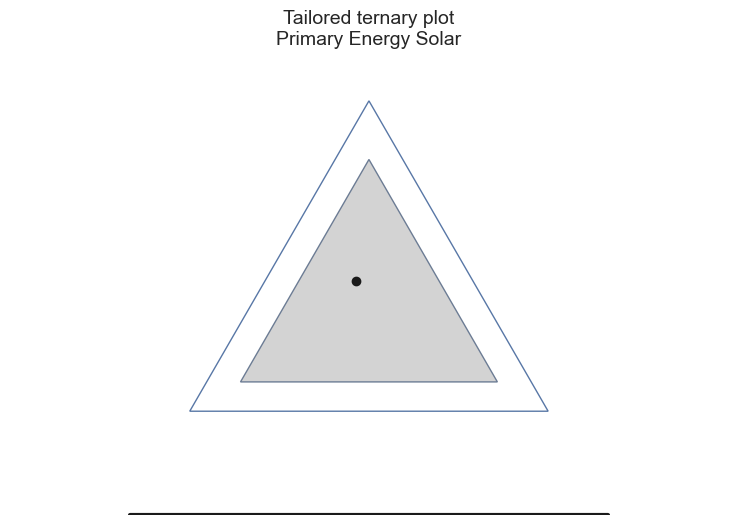

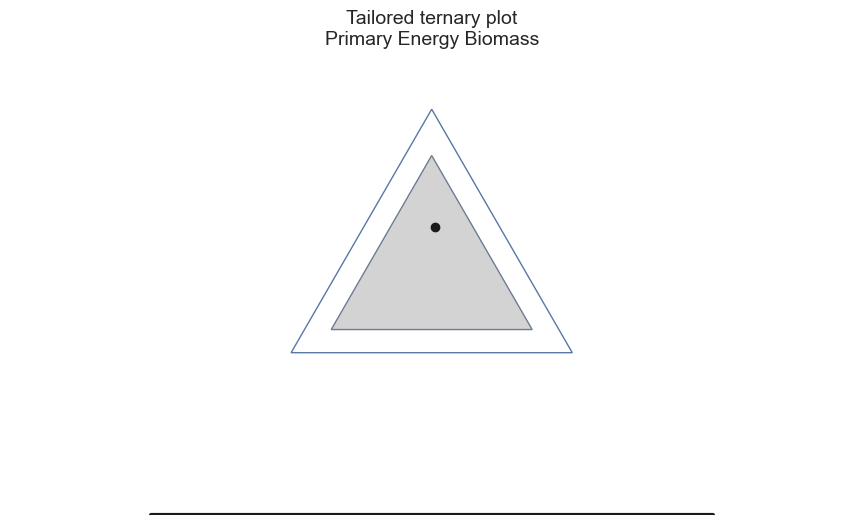

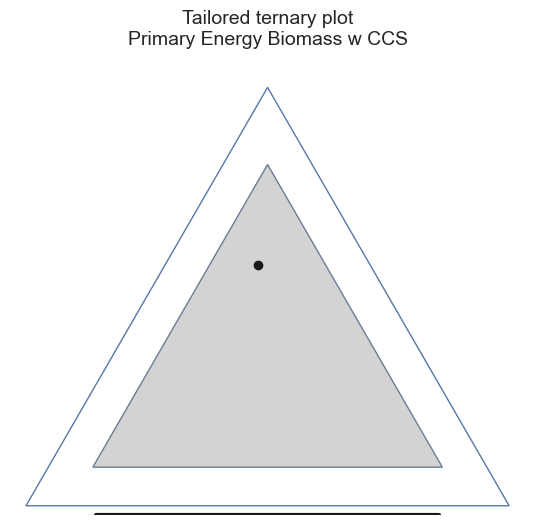

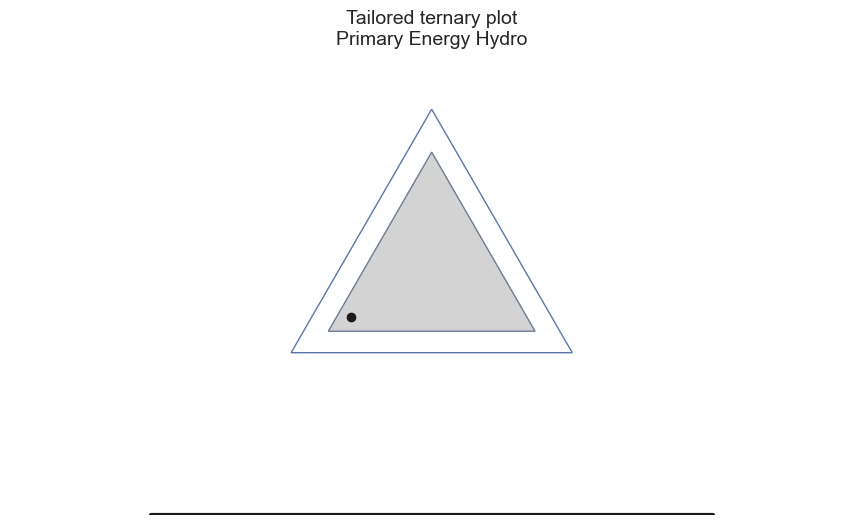

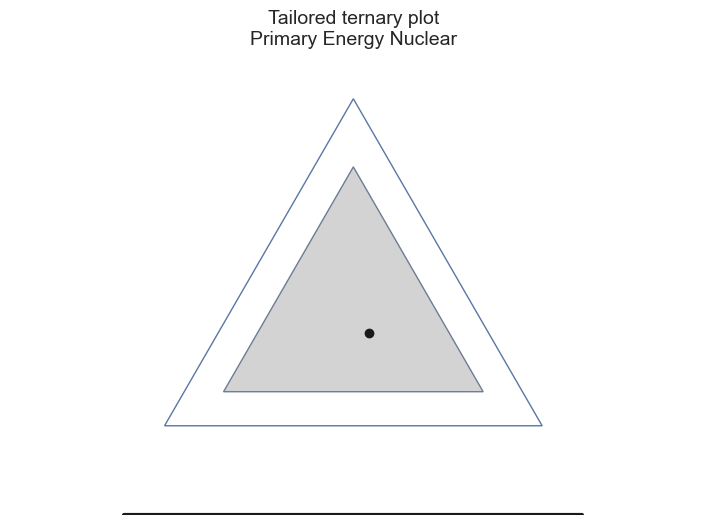

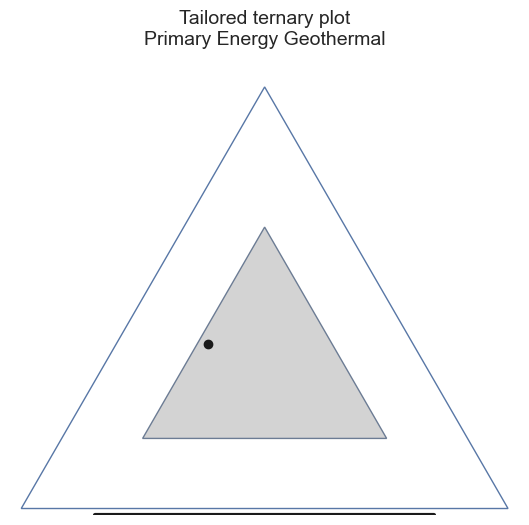

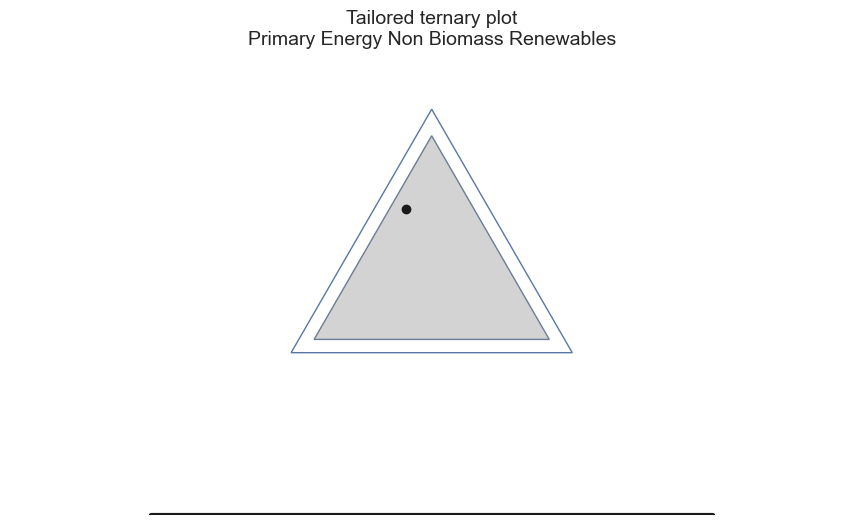

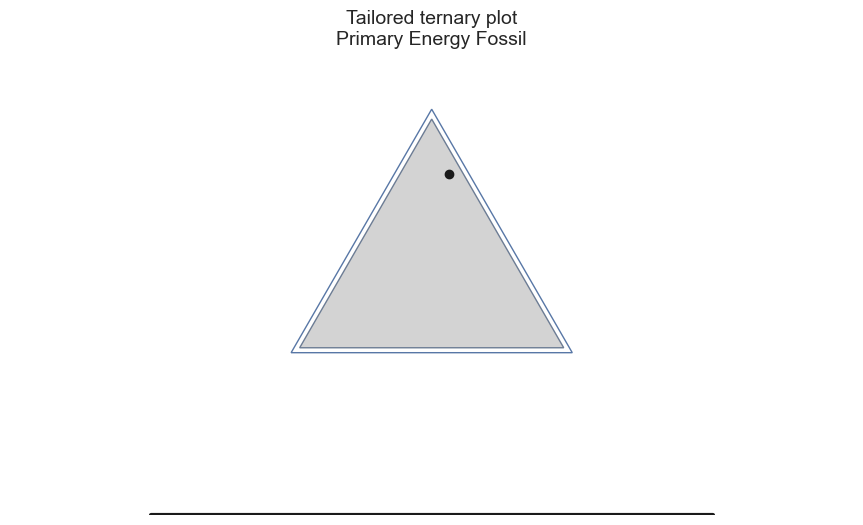

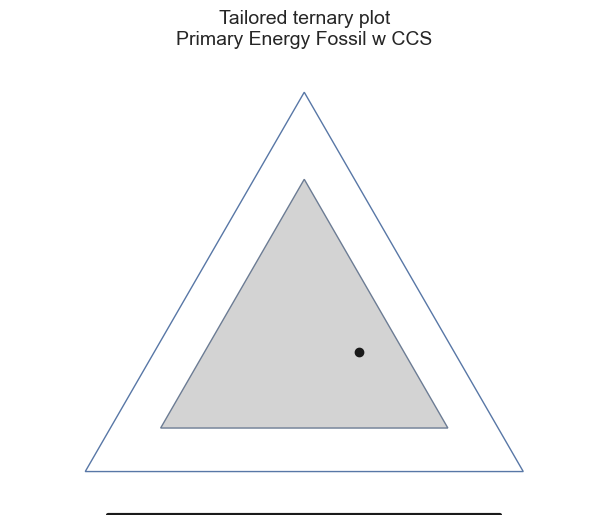

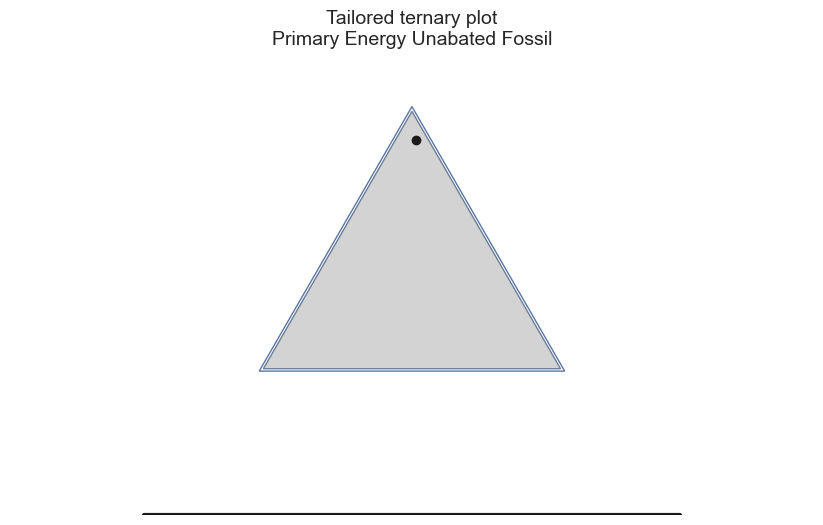

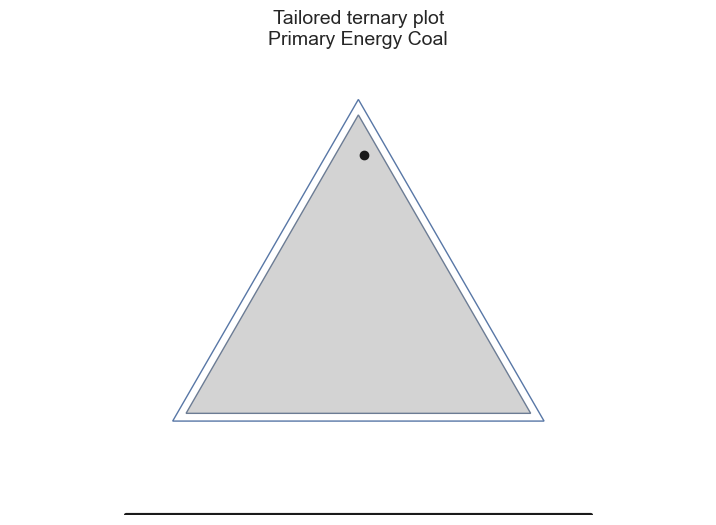

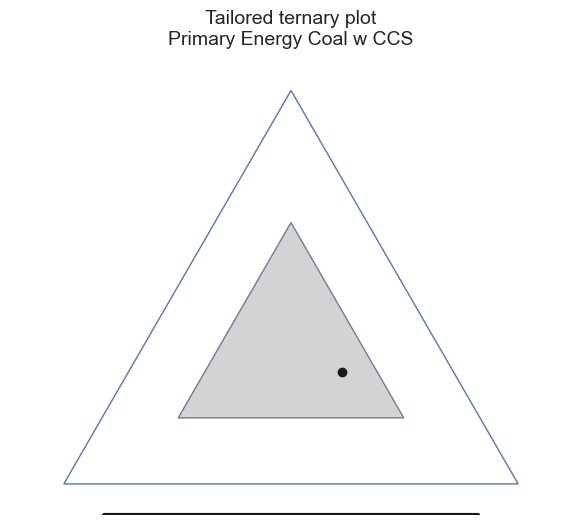

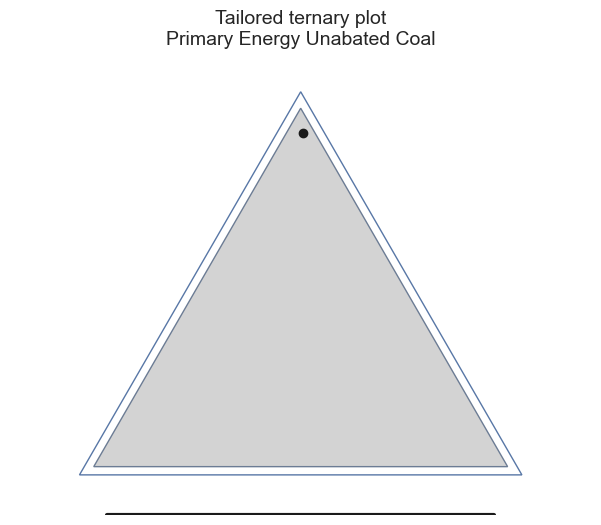

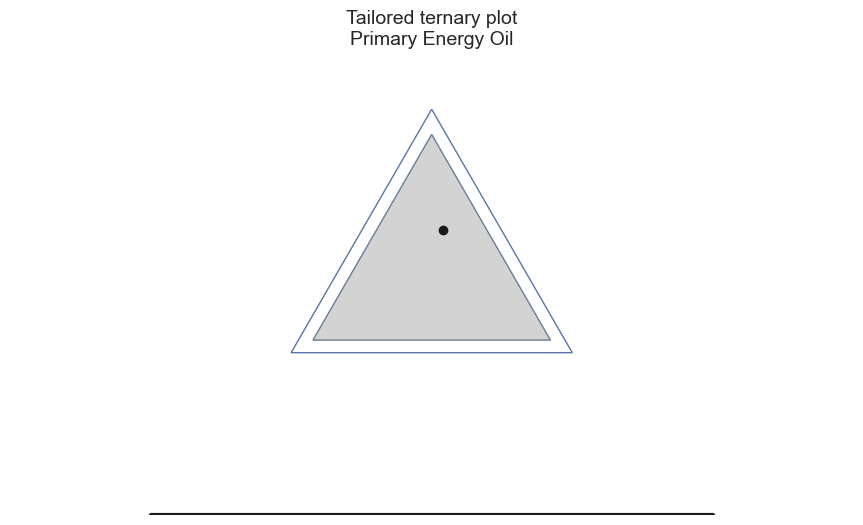

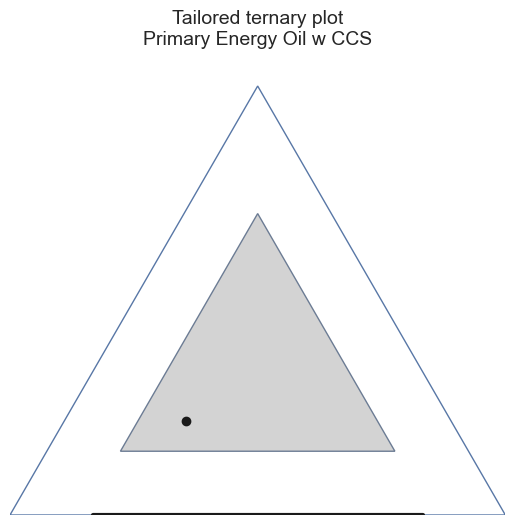

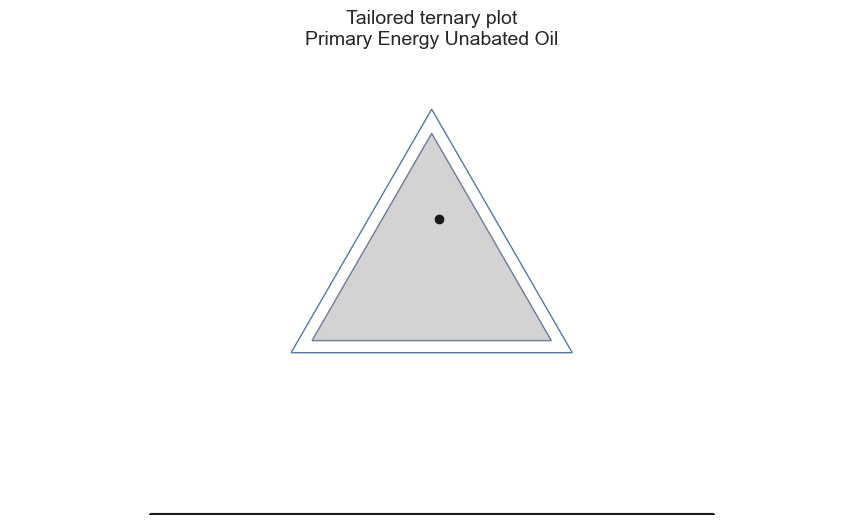

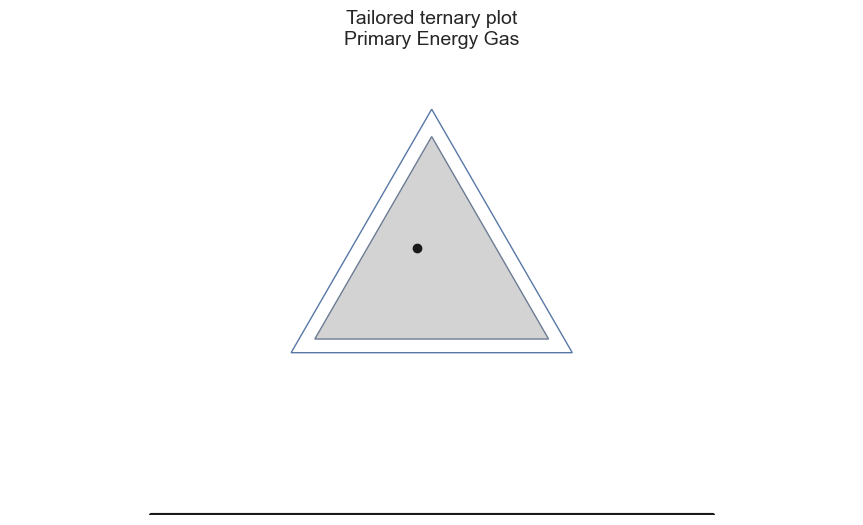

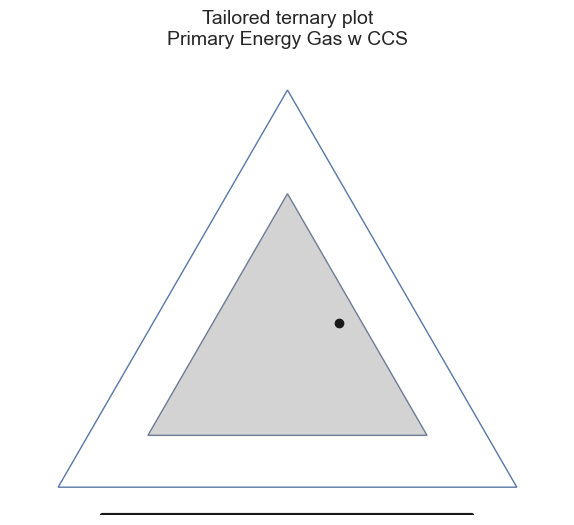

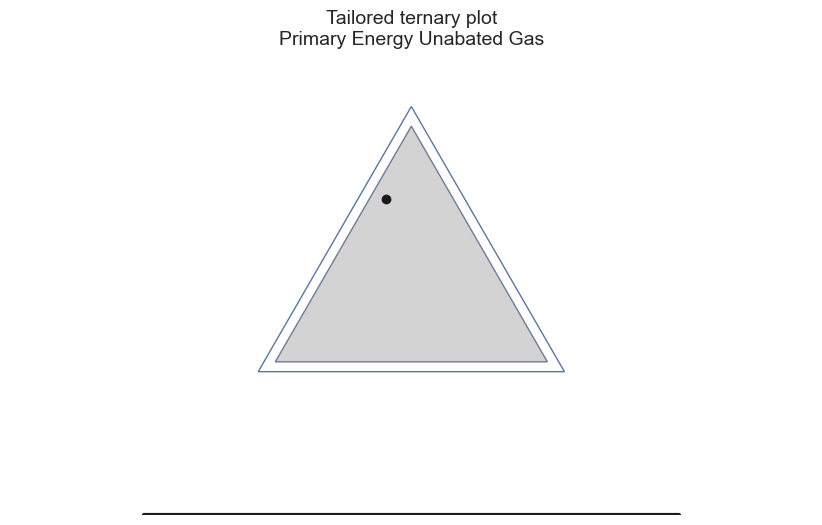

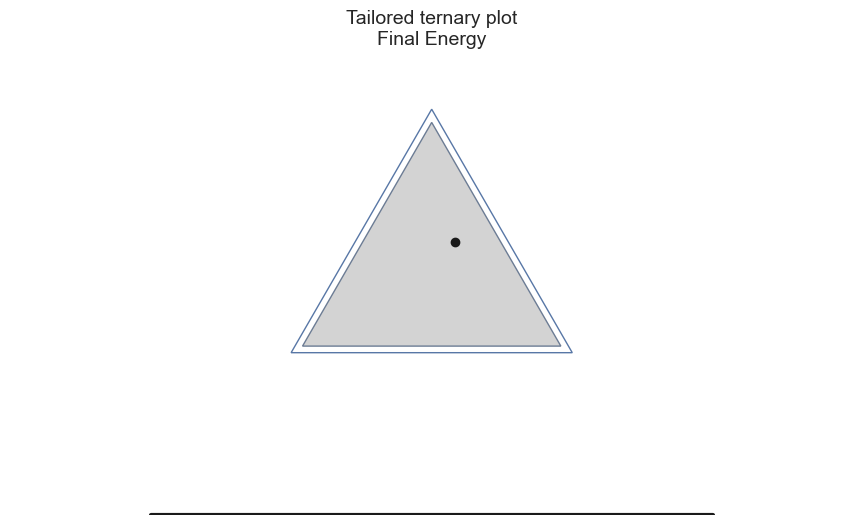

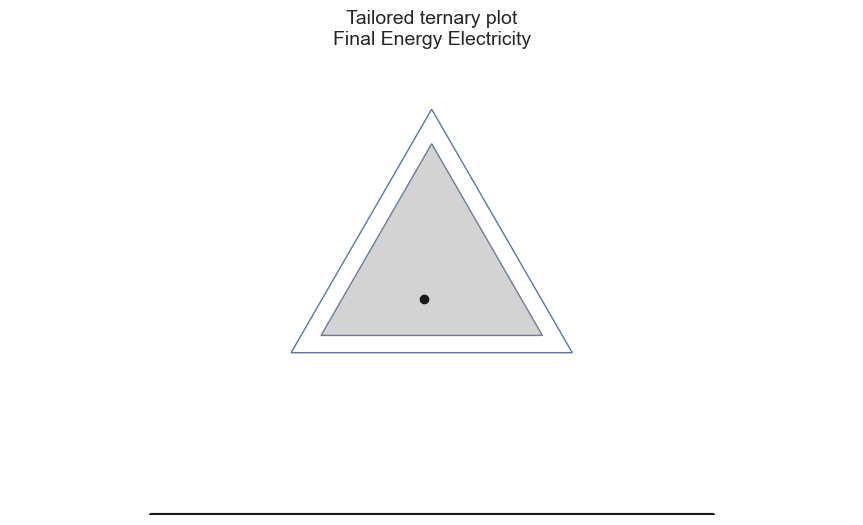

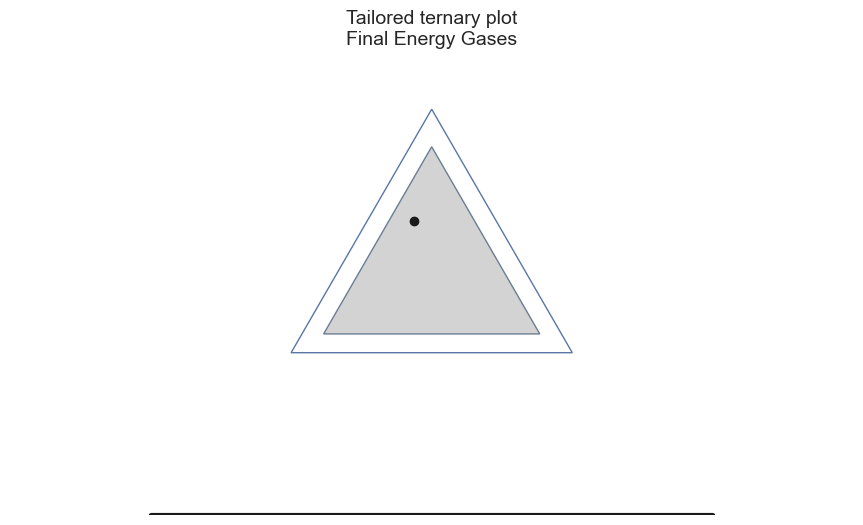

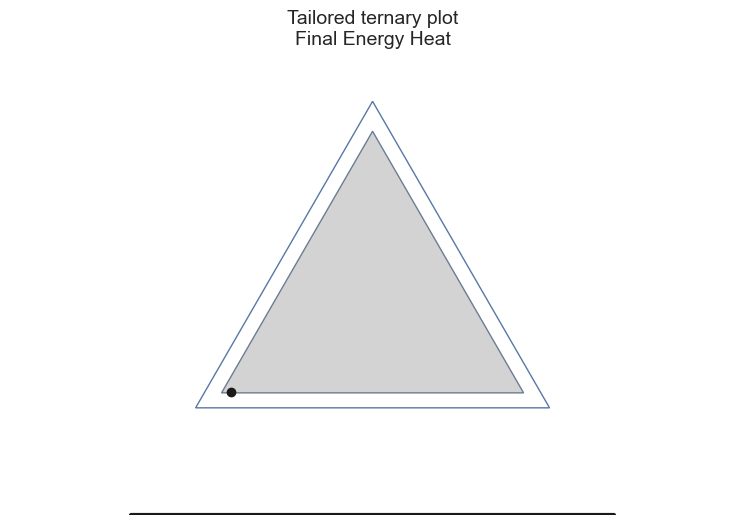

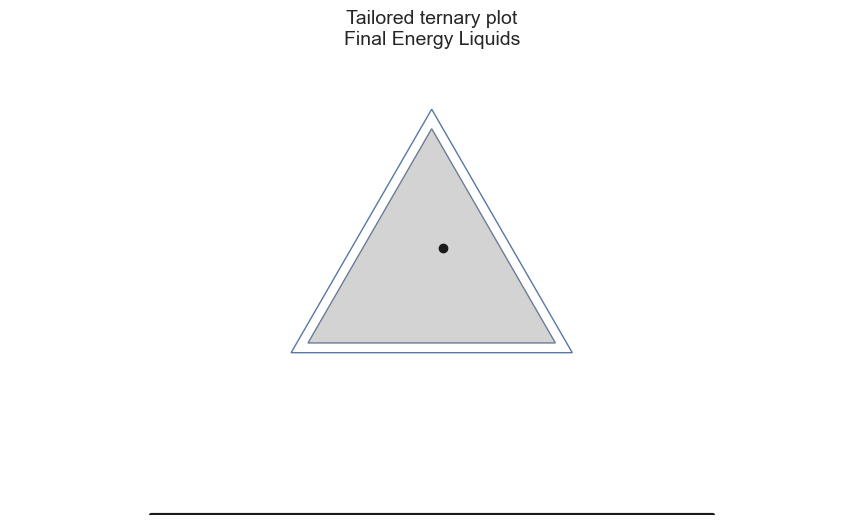

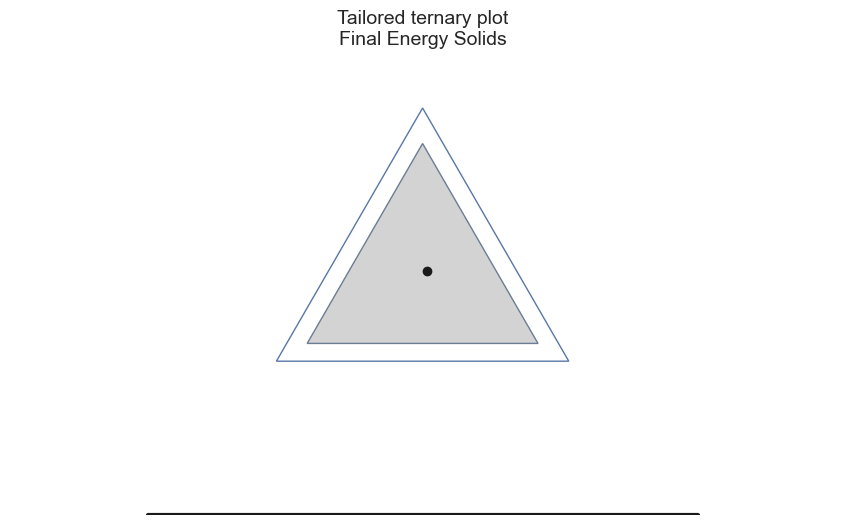

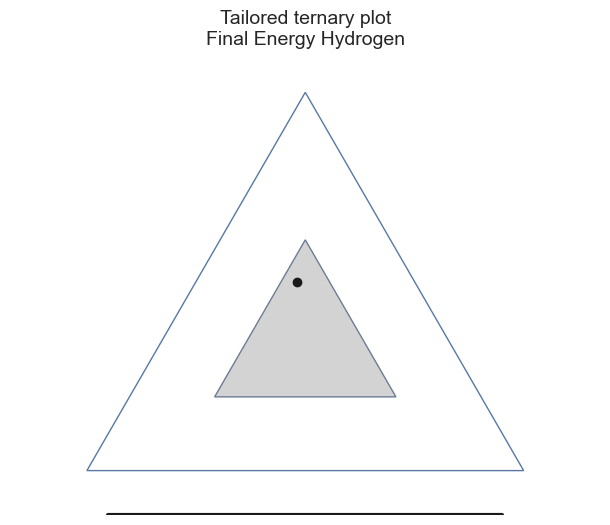

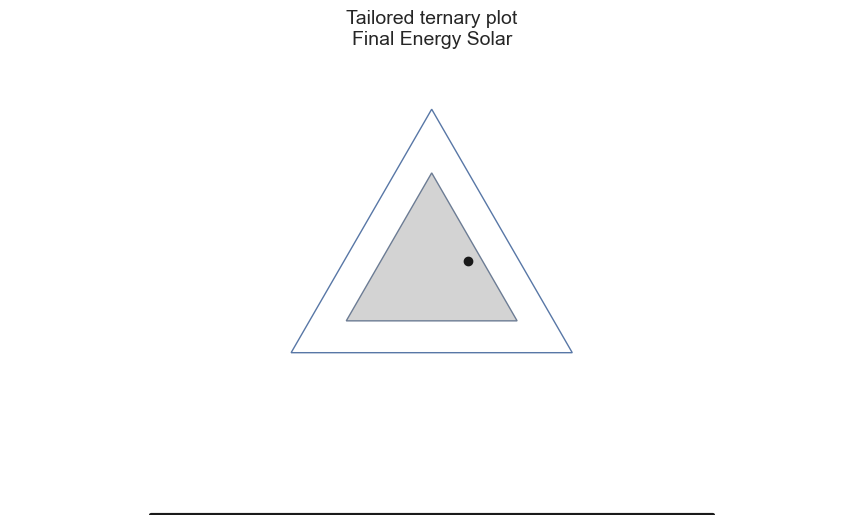

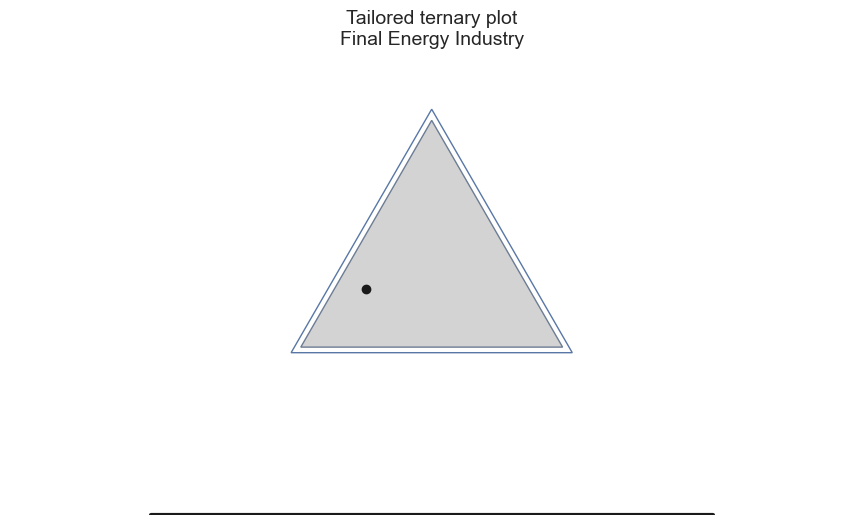

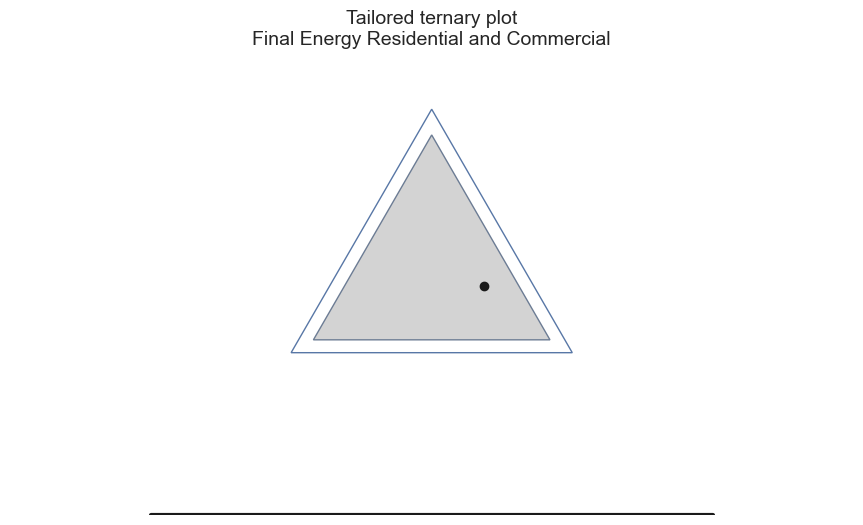

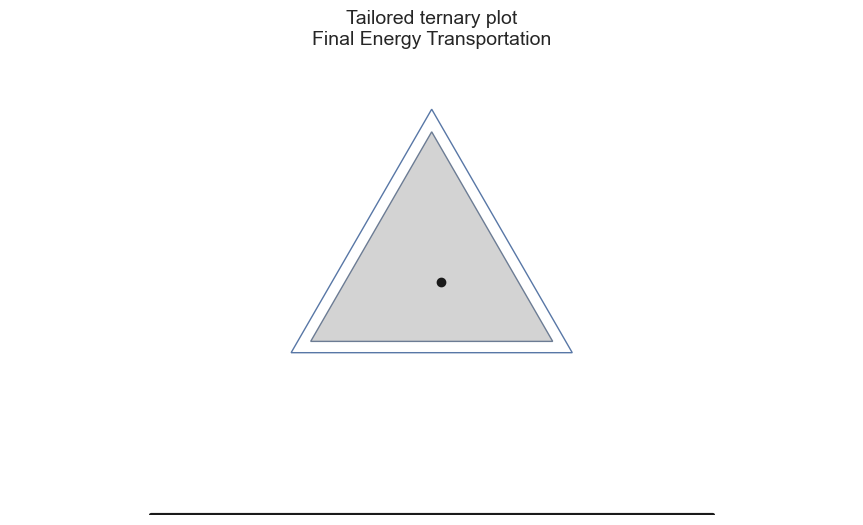

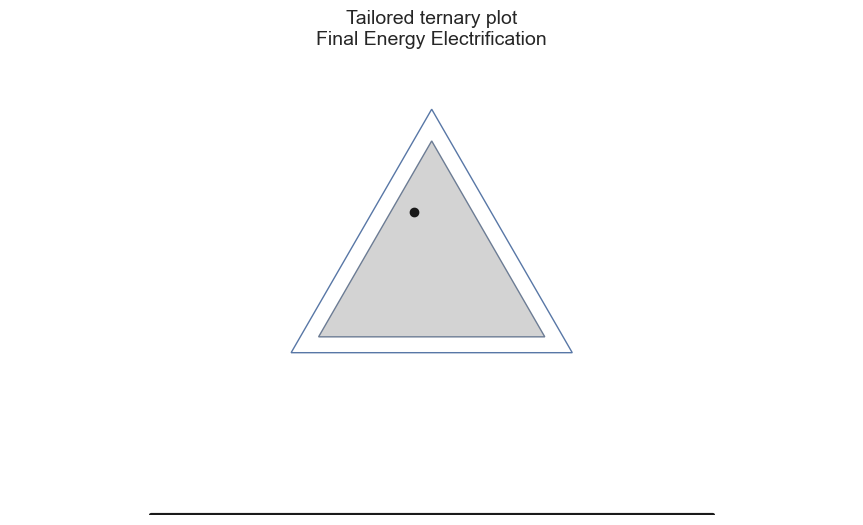

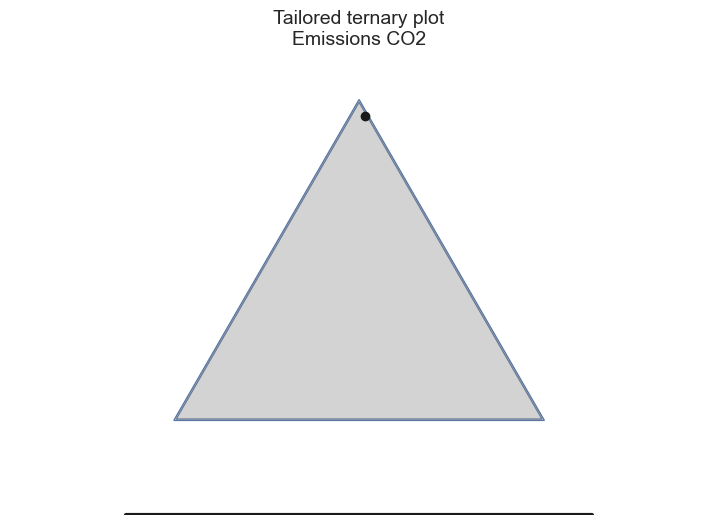

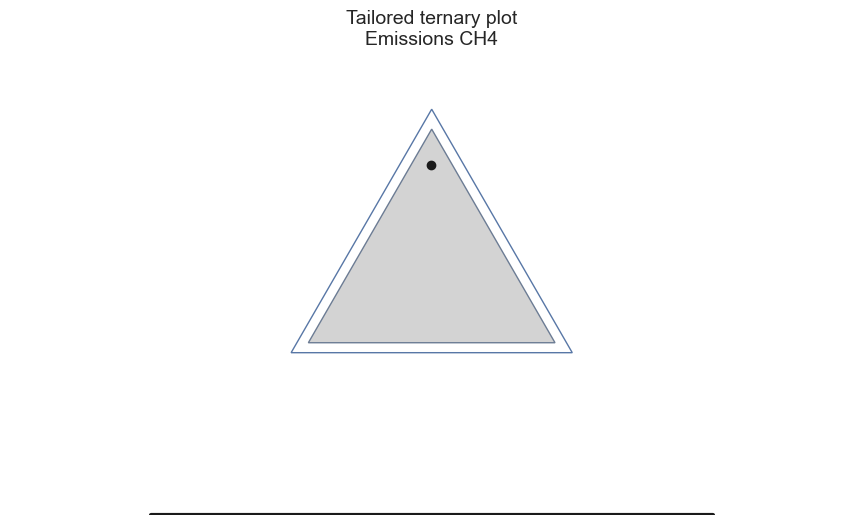

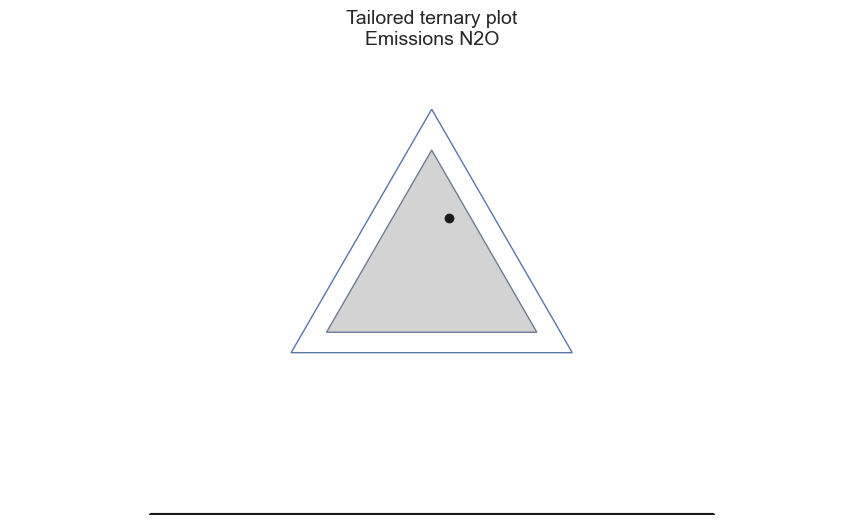

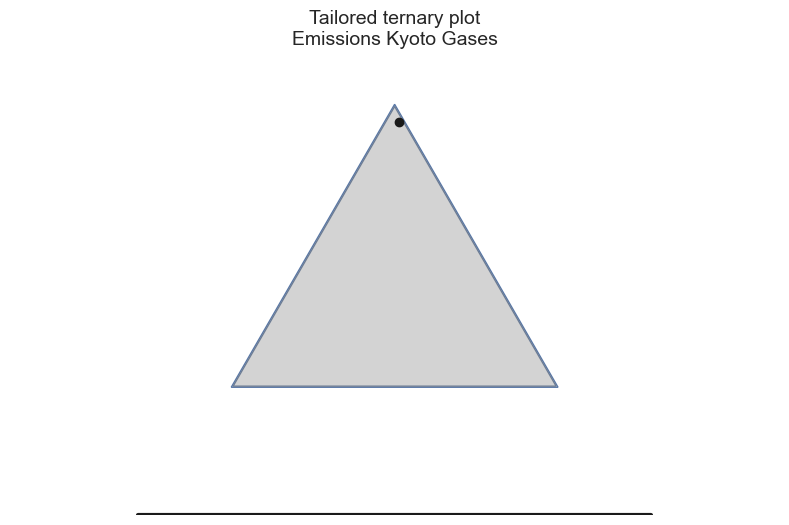

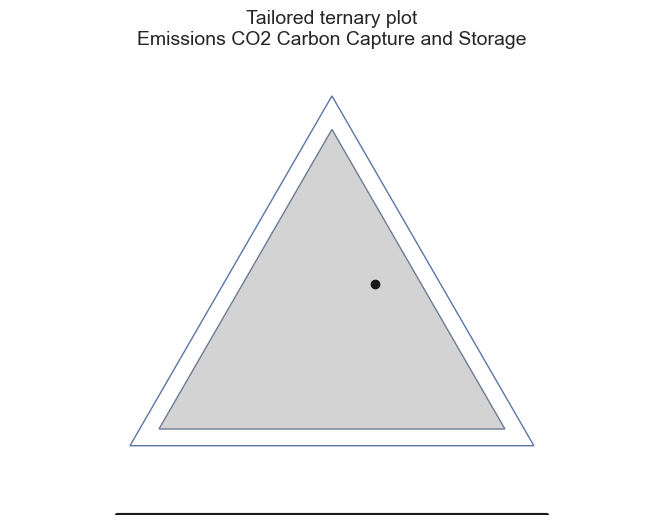

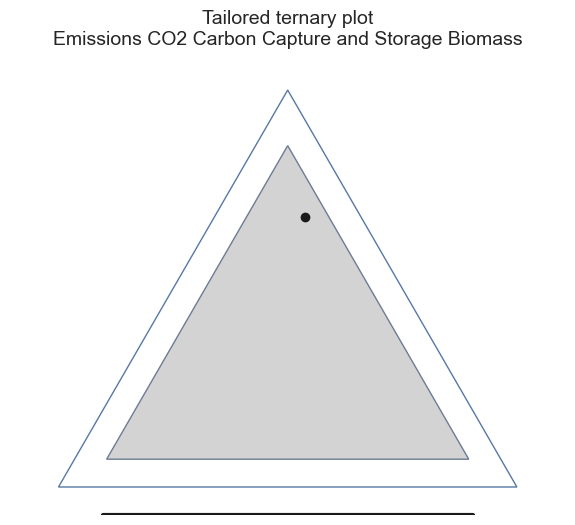

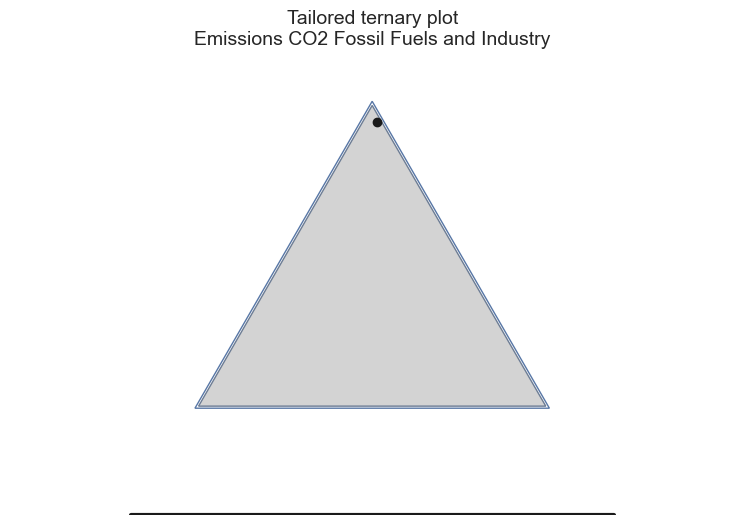

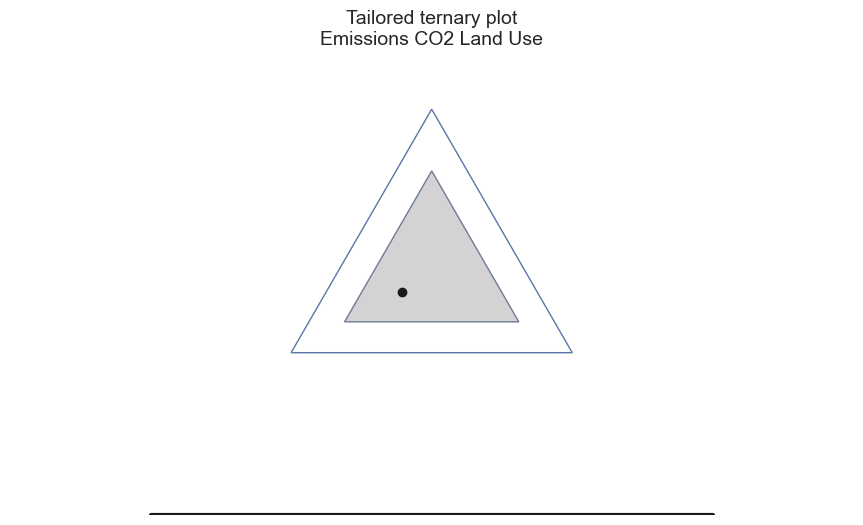

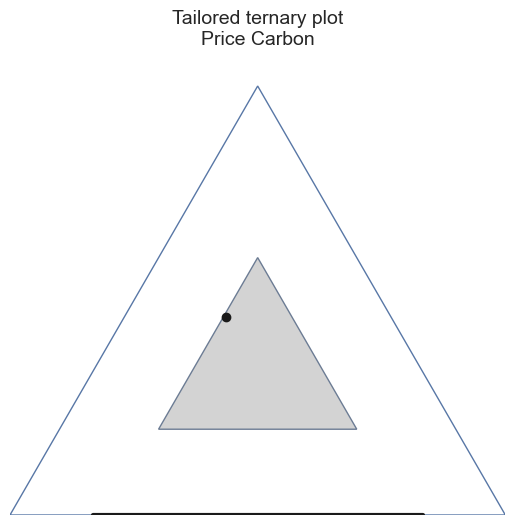

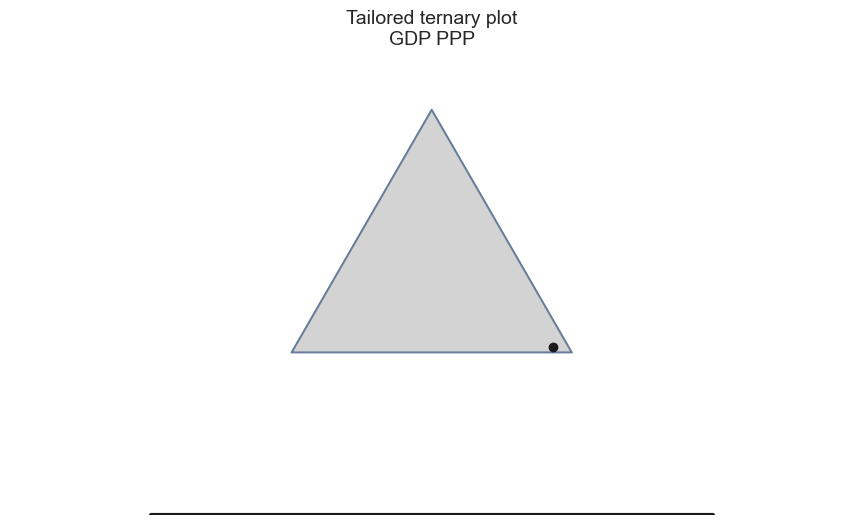

In [17]:
# --------------
# Data for 2060 
# --------------
df_all_2060 = df_all.query('Year == 2060')

# --------------
# Plotting
# --------------

# Set the parameters for the plot
sns.set()
sns.set_style("white")
plt.rcParams['figure.dpi']= 100
plt.rcParams['figure.figsize'] = (12,6)
plt.rc("savefig", dpi=150)
plt.rc("font", size=14)

# Loop over each unique variable in the 'Variable' column
for variable in df_all_2060['Variable'].unique():
    
    # Filter the DataFrame for the current variable
    df_variable = df_all_2060[df_all_2060['Variable'] == variable].iloc[0]

    # Create the figure and axis for each variable
    fig, ax = plt.subplots()

    # Plot the outer triangle
    outer_triangle = patches.Polygon([[df_variable['X_outer_left'], df_variable['Y_outer_base']],
                                      [df_variable['X_outer_right'], df_variable['Y_outer_base']],
                                      [df_variable['X_outer_top'], df_variable['Y_outer_top']]], closed=True, fill=None, edgecolor='#5877a6')
    ax.add_patch(outer_triangle)

    # Plot the inner triangle, shaded in grey
    inner_triangle = patches.Polygon([[df_variable['X_inner_left'], df_variable['Y_inner_base']],
                                    [df_variable['X_inner_right'], df_variable['Y_inner_base']],
                                    [df_variable['X_inner_top'], df_variable['Y_inner_top']]], closed=True,
                                    fill=True, facecolor='lightgrey', edgecolor='#6c7c94')
    ax.add_patch(inner_triangle)


    # Plot the data point
    ax.plot(df_variable['X_data_point'], df_variable['Y_data_point'], 'ko')  

    # Plot the base line using the unit length, from ~16% to ~83% of the axis length
    ax.plot([0.16667 * axis_length, 0.83333 * axis_length], [0, 0], 'k-', linewidth=3)

    # Set the aspect of the plot to be equal
    ax.set_aspect('equal')

    # Remove the axis from the final display
    ax.axis('off')

    # Limit the plot to the triangle size
    ax.set_xlim([0, axis_length])
    ax.set_ylim([0, df_variable['Y_outer_top'] + 0.1])

    ax.set_title('Tailored ternary plot\n{}'.format(variable), fontsize=14, ha='center')
    plt.savefig(f'Tailored ternary plot for {variable}.png')
    plt.show()
